# Exploratory data analysis
Whenever you collect a new dataset, a good first step is to explore it. This means different things for different kinds of datasets, but if it's a timeseries then there are common techniques that will likely prove useful. This tutorial covers the basics of exploratory data analysis with timeseries. It focuses on raster plots and PSTHs recorded from spiking neurons, though the principles extend to most timeseries data.

# Data and Task
The dataset was recorded from M1 neurons in a monkey performing a center-out reaching task. The monkey had to reach towards different targets, each at a different angle. On each trial, the target angle and onset was recorded.

In [3]:
import numpy as np
from scipy import io as si
from matplotlib import pyplot as plt
import h5py
%matplotlib inline

# Load the data
First we'll load the data - an important first step in any analysis is determining the structure of the data. This is particularly important if you've never analyzed the data before. Let's take a look at our data.

In [18]:
data = si.loadmat('../../data/StevensonV4.mat')
type(data)

dict

It looks like our data is a dictionary, which means it has keys and values:

In [22]:
for key in data.keys():
    print(key)

handPos
spikes
timeBase
target
handVel
__header__
__globals__
startBinned
time
targetsAngles
targetNumbers
__version__
targets
startBins


These are all fields contained within data, corresponding to the data contained within it. The fields beginning with `__` correspond to the fact that this dataset was saved with matlab. These are automatically inserted and we can probably ignore them.

Let's take a look at our spiking data

In [23]:
# Load in the spiking data
spikes = data['spikes']

In [24]:
spikes.shape

(196, 776789)

Judging from the size of each axis, it looks like we have an array of shape (n_neurons, n_times). We can determine the time step for each bin by looking at the `timeBase` variable. We can use this to create the time of our data

In [29]:
time_step = data['timeBase'].squeeze()
times = np.arange(spikes.shape[-1]) * time_step
print(time_step)
print(times[:10])

0.001
[ 0.     0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009]


A good first step with raster plots is to calculate summary statistics of the activity. First we'll take a look at the mean activity across time (averaging across neurons), then we'll look at the distribution of spikes across neurons (aggregating across time).

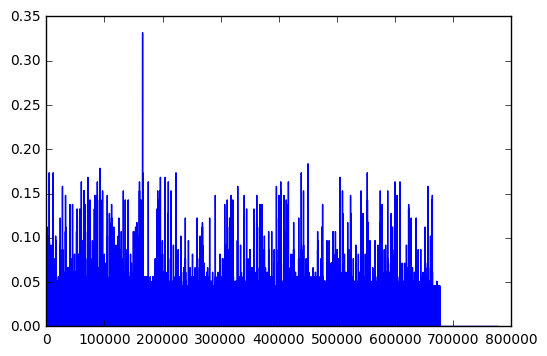

In [31]:
# Calculate the mean across neurons and plot it for a quick viz
mean_spikes = np.mean(spikes, 0)
fig, ax = plt.subplots()
ax.plot(mean_spikes)

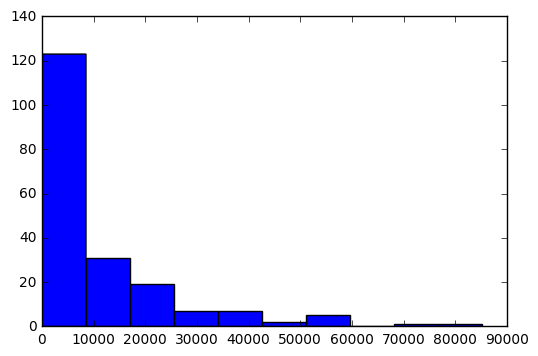

In [33]:
total_spikes = np.sum(spikes, -1)
fig, ax = plt.subplots()
_ = ax.hist(total_spikes)

Now let's pull out the activity of a single neuron and see what it looks like:

In [37]:
neuron_ix = 192 # Which neuron are we looking at?
neuron = spikes[neuron_ix]
ixs_spikes = np.where(neuron == 1)[0]

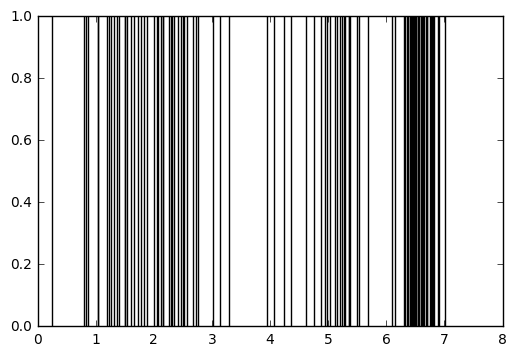

In [44]:
fig, ax = plt.subplots()
ax.vlines(times[ixs_spikes[:100]], 0, 1)

These vertical lines represent the spikes of a single neuron. We can visualize all of the neurons at once (but more on that later).

# Binning by events
It's generally true that the neural activity we record can be split up in to distinct "events" that occur at a moment in time. Let's slice up our data based on the event times in `startBins` and see how this looks. We've also got information about event types in the field `targetNumbers`.

In [49]:
# Only process what constitutes valid trials - identify malformed ones
start_bins = data['startBins'][0]
target_numbers = data['targetNumbers'][:, 0]
print(start_bins.shape)


(180,)


In [51]:
# We'll only keep the trials that occur before a pre-specified time
end_ix = 676790
mask_keep = start_bins < end_ix
start_bins = start_bins[mask_keep]
target_numbers = target_numbers[mask_keep]
print(start_bins.shape)


(155,)


At this point, we'd generally need to clean up the data. This might mean throwing away neurons that had a bad signal, or events where there was clearly noise being recorded. In this case, the data is relatively clean already (thanks to Konrad for this).

We'll create a dictionary that lets us map each condition type onto times corresponding to events of that condition.

In [54]:
n_conditions = len(np.unique(target_numbers))
print('Number of conditions: {}'.format(n_conditions))

condition_dict = {}
for ii in range(1, n_conditions + 1):
    condition_dict[ii] = np.where(target_numbers == ii)[0]

Number of conditions: 8


#  Visualizing event-related activity
Now that we know when each event occurs, let's visualize the activity of our focus neuron. To do this, we'll need to pull a *window* of time around each event. Then we can see the activity during that window.

In [55]:
# We infer the sfreq from the time step
sfreq = 1. / time_step

# Define how we'll take a window around each event
tmin, tmax = -.5, 10
ixmin = int(tmin * sfreq)
ixmax = int(tmax * sfreq)

In [56]:
# Now loop through conditions
cond_data = {}
for cond in range(1, n_conditions + 1):
    # For each condition, we'll take a window of time around each onset
    indices = condition_dict[cond]
    this_onsets = start_bins[indices]

    # Loop through each event for this event
    epochs = []
    for onset in this_onsets:
        if (onset + ixmax) > spikes.shape[-1]:
            # If the window extends beyond the data, skip it
            continue
        epochs.append(spikes[:, onset + ixmin : onset + ixmax])
    epochs = np.array(epochs)
    cond_data[cond] = epochs
    
# Now create time (in seconds) around each window
time_epochs = np.linspace(tmin, tmax, num=epochs.shape[-1])

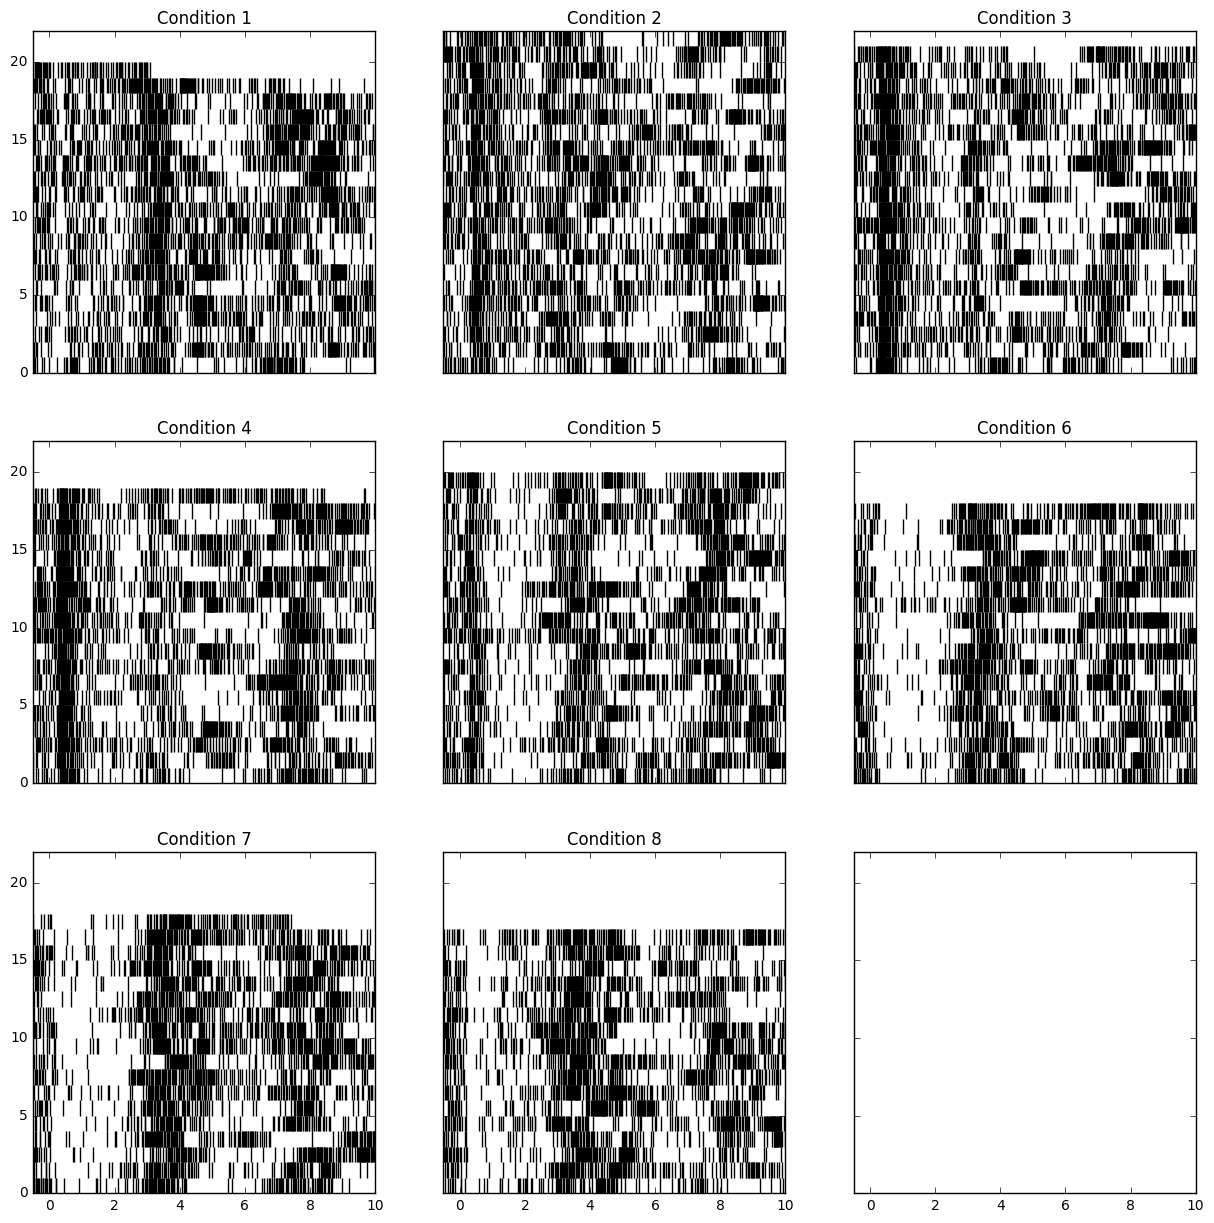

In [59]:
# Now, we can plot the spiking activity (rasters) in response to each condition
n_row = 3
n_col = int(np.ceil(n_conditions / float(n_row)))
fig, axs = plt.subplots(n_row, n_col, sharex=True, sharey=True,
                        figsize=(5 * n_col, 5 * n_row))
for ax, (cond, i_data) in zip(axs.ravel(), cond_data.items()):
    this_epoch = i_data[:, neuron_ix, :]
    for ii, i_ep in enumerate(this_epoch):
        mask_spikes = i_ep == 1
        ixs_spikes = np.where(mask_spikes)[0]
        times_spikes = time_epochs[ixs_spikes]
        if len(times_spikes) > 0:
            ax.vlines(times_spikes, ii, ii + 1, color='k')
    ax.set_title('Condition {}'.format(cond))
    plt.autoscale(tight=True)

# Visualizing with a Peri-Stimulus Time Histogram (PSTH)
It is helpful to summarize the spiking activity across repetitions of one condition. For this, we create the peri-stimulus time histogram (PSTH). This shows us the general pattern of spiking activity in response to a stimulus.

In [60]:
# We'll use this to smooth in time, which is important when using spikes
from scipy.ndimage.filters import gaussian_filter1d

To create teh PSTH we'll need to smooth the spikes in time. This effectively converts the spikes from bins to a continuously-varying spike rate. We'll smooth using a gaussian distribution...if we want a smoother spike rate, we should increase the standard deviation of the gaussian.

In [67]:
# Smooth the spiking activity, then take every "Nth" sample to reduce size
gaussian_sd = 10
n_decimate = 5
binned_dict = {}
for i_cond, i_data in cond_data.items():
    i_data = gaussian_filter1d(i_data.astype(float), gaussian_sd, axis=-1)
    # We'll take every Nth sample to speed up plotting
    i_data = i_data[..., ::n_decimate]
    binned_dict[i_cond] = i_data

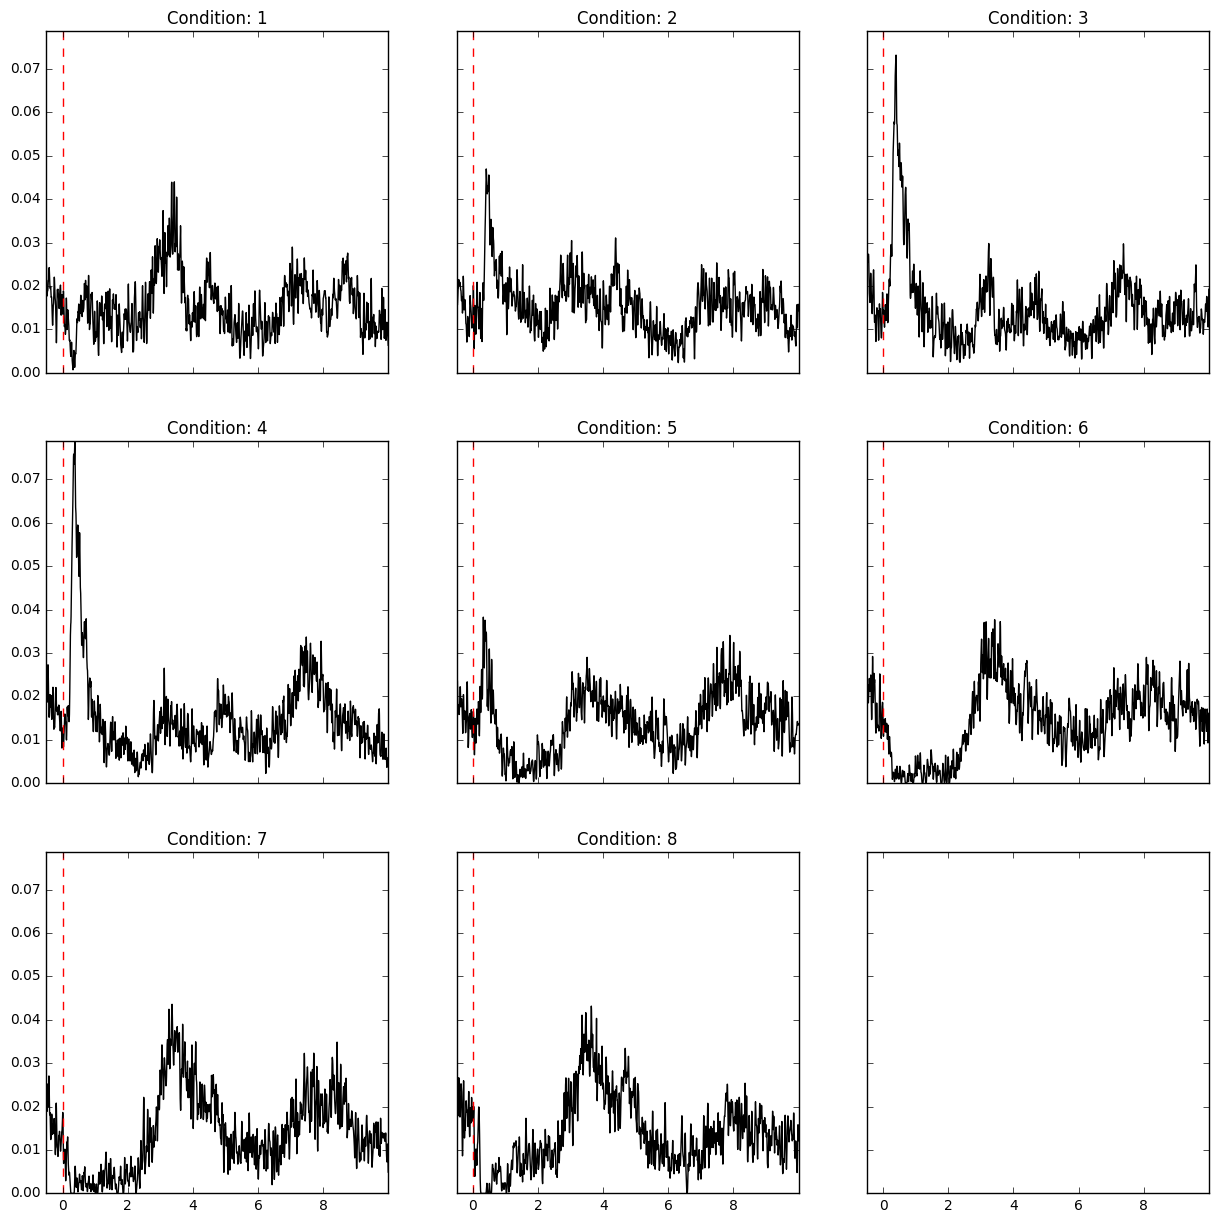

In [68]:
# Compare this plot with the raster images above
n_row = 3
n_col = int(np.ceil(n_conditions / float(n_row)))
fig, axs = plt.subplots(n_row, n_col, sharex=True, sharey=True,
                        figsize=(5 * n_col, 5 * n_row))
for ax, (i_cond, i_data) in zip(axs.ravel(), binned_dict.items()):
    ax.plot(time_epochs[::n_decimate], i_data.mean(0)[192], 'k')
    ax.set_title('Condition: {}'.format(i_cond))
    ax.axvline(0, color='r', ls='--')
plt.autoscale(tight=True)

The PSTH is a summary of activity, and as such it more useful in understanding what is going on. However, as with any summary statistic, we've also removed some information about the data (we did this when collapsing across trials). Be careful to consider what information you may be removing (and what assumptions you may be violating) when you calculate statistics.

Now we've got a general idea of what's going on with this dataset. We have a number of neurons, and several types of trials. If we wanted to determine if activity was different from one trial to the next, we'd have to run some stats on this data. More on that in the other notebooks.